Counterfactuals provide the solution or changes in prediction to “What if” cases by showing feature-perturbed versions of the same cases. If X is an independent variable and Y is a dependent variable, counterfactual shows the effect on Y due to small changes in X. Also, it helps to calculate,what changes need to be done in X if the outcome Y is changed to Y'.

##Counterfactual instances on Fashion MNIST

In [1]:
!pip install alibi

In [2]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import CounterFactual
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.3.0
Eager execution enabled:  False


Load MNIST data

x_train shape: (60000, 28, 28) y_train shape: (60000,)


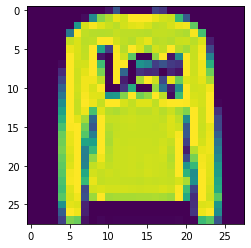

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.imshow(x_test[1]); #just an example of the dataset

Scale, reshape and categorize(one-hot encoding) 

In [4]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [5]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

Define and train CNN model

In [6]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

In [7]:
cnn = cnn_model()
cnn.summary()
cnn.fit(x_train, y_train, batch_size=64, epochs=3, verbose=0)
cnn.save('mnist_cnn.h5')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)         

Calculate the error for evaluation of model

In [8]:
cnn = load_model('mnist_cnn.h5')
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Test accuracy:  0.8845


Since the accuracy is 98%, the model is good.

Since counterfactual is a local explanation method, we focus on one particular instance i.e. index 4 of test data which is an image of a shirt (class 6) as shown below.

Prediction on instance to be explained: [6]
Prediction probabilities for each class on the instance: [[5.8704022e-02 8.7378394e-05 4.4621732e-02 1.8209884e-02 1.5343936e-02
  5.4412929e-05 8.6157715e-01 1.9099751e-05 1.1396524e-03 2.4279625e-04]]


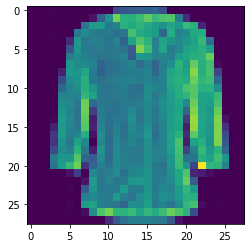

In [9]:
X = x_test[4].reshape((1,) + x_test[0].shape)
plt.imshow(X.reshape(28, 28));
print('Prediction on instance to be explained: {}'.format([np.argmax(cnn.predict(X))]))
print('Prediction probabilities for each class on the instance: {}'.format(cnn.predict(X)))

Generate counterfactuals

Counterfactual parameters -

target_proba: This is the probability required for the returned target class after applying counterfactual. 

tol: the tolerance within the target_proba, this is used to specify a range of acceptable predicted probability values for flexibility in target_proba.

target_class: desired target class for the returned counterfactual instance. 

feature_range: feature-wise min and max values for the perturbed instance.

max_iter, lam_init, max_lam_steps, learning_rate_init are all mathematical parameters used for the method.

learning_rate_init: initial learning rate

lam_init: initial value of the hyperparameter λ. 

max_lam_steps: the number of steps (outer loops) to search for with a different value of λ.

In [10]:
shape = (1,) + x_train.shape[1:] #reshaping according to batch dimension, which is here 1, so 1 column is added.
target_proba = 1.0
tol = 0.01 # tolerance - want counterfactuals with p(class)>0.99
target_class = 'other' # any class other than the class of the test instance (here 7).
max_iter = 1000
lam_init = 1e-1
max_lam_steps = 10
learning_rate_init = 0.1
feature_range = (x_train.min(),x_train.max())

Run counterfactual

In [11]:
# initialize explainer
cf = CounterFactual(cnn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                    max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                    feature_range=feature_range)

start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 10.382 sec


Counterfactual prediction: 0 with probability 0.9927460551261902


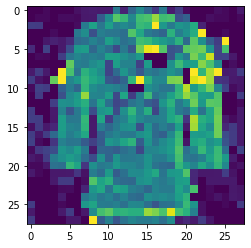

In [12]:
pred_class = explanation.cf['class']
proba = explanation.cf['proba'][0][pred_class]

print(f'Counterfactual prediction: {pred_class} with probability {proba}')
plt.imshow(explanation.cf['X'].reshape(28, 28));

A counterfactual explanation of a prediction describes the smallest change to the feature values that changes the prediction to a predefined output.
Here, the counterfactual starting from a class 6 which is shirt, makes perturbations in the pixels and moves towards the closest class in the data, that is in this case class 0 (t-shirt/top). As required, the probability of the returned counterfactual is 0.99 which is quite high.

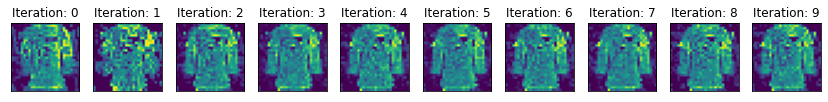

In [13]:
n_cfs = np.array([len(explanation.all[iter_cf]) for iter_cf in range(max_lam_steps)])
examples = {}
for ix, n in enumerate(n_cfs):
    if n>0:
        examples[ix] = {'ix': ix, 'lambda': explanation.all[ix][0]['lambda'],
                       'X': explanation.all[ix][0]['X']}
columns = len(examples) + 1
rows = 1

fig = plt.figure(figsize=(16,6))

for i, key in enumerate(examples.keys()):
    ax = plt.subplot(rows, columns, i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(examples[key]['X'].reshape(28,28))
    plt.title(f'Iteration: {key}')

The transformation of shirt to t-shirt over several iterations is shown in the above image. The image is not very clear but it can be seen how the counterfactual perturbations are generated to change the prediction class.

Now, we have specified the target class as 4 which means that for the outcome of model prediction to be 4 (coat), what are the changes in features(pixels here) required.

In [23]:
target_class = 4
cf = CounterFactual(cnn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                    max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                    feature_range=feature_range)

explanation = start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 8.339 sec


Counterfactual prediction: 4 with probability 0.9908218383789062


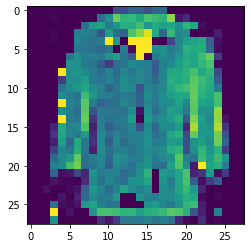

In [24]:
pred_class = explanation.cf['class']
proba = explanation.cf['proba'][0][pred_class]

print(f'Counterfactual prediction: {pred_class} with probability {proba}')
plt.imshow(explanation.cf['X'].reshape(28, 28));

Here, we have explicitly specified the output class and the counterfactual perturbations are made accordingly.

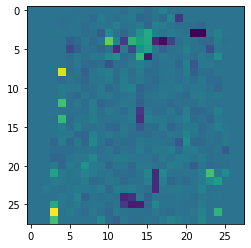

In [25]:
plt.imshow((explanation.cf['X'] - X).reshape(28, 28));

The above image shows the difference between the counterfactual and the original instance. This helps in concluding that the counterfactual is removing and adding to some parts of the shirt image with some changes in the shape to result in a prediction of 4. For example, the length of the sleeves is longer on coat, thus the pixels at that point are changed accordingly to make them look longer. Thus, we know that it is working correctly.